# 01 - Data Collection & Preprocessing

**Goal:** Download market data, calculate technical indicators, and prepare features for our DQN trading agent.

---

## What We'll Do

1. Download SPY (S&P 500 ETF) historical data from Yahoo Finance
2. Calculate **21 technical indicators** for our agent's state space
3. Handle missing values and validate data quality
4. Save processed data for training

## Why These Steps Matter

- **Quality data** = Better agent performance
- **Technical indicators** = Give agent market context (momentum, trend, volatility)
- **Proper preprocessing** = Prevent data leakage and ensure realistic simulation

---

In [3]:
# Setup and imports
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")
print(f"✓ pandas: {pd.__version__}")
print(f"✓ yfinance: {yf.__version__}")

✓ Imports successful
✓ pandas: 2.3.2
✓ yfinance: 0.2.66


## Step 1: Download Market Data

We'll download **SPY** (S&P 500 ETF) data from 2000 to present.

**Why SPY?**
- Highly liquid (easy to trade)
- Low spreads
- Represents overall market
- Long history available

In [4]:
# Download SPY data
print("Downloading SPY data from Yahoo Finance...")

ticker = "SPY"
start_date = "2000-01-01"
end_date = "2024-12-31"

# Download
spy_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Fix MultiIndex columns issue - flatten if needed
if isinstance(spy_data.columns, pd.MultiIndex):
    spy_data.columns = spy_data.columns.get_level_values(0)

# Convert column names to lowercase
spy_data.columns = spy_data.columns.str.lower()

# Add ticker column
spy_data['ticker'] = ticker

print(f"\n✓ Downloaded {len(spy_data)} days of data")
print(f"  Date range: {spy_data.index[0].date()} to {spy_data.index[-1].date()}")
print(f"  Columns: {list(spy_data.columns)}")

# Display first few rows
spy_data.head()


✓ Downloaded 6288 days of data
  Date range: 2000-01-03 to 2024-12-30
  Columns: ['close', 'high', 'low', 'open', 'volume', 'ticker']


Price,close,high,low,open,volume,ticker
Date,,,,,,
2000-01-03,91.887764,93.664708,90.900573,93.664708,8164300,SPY
2000-01-04,88.294403,91.019051,88.225300,90.683406,8089800,SPY
2000-01-05,88.452385,89.419833,86.714927,88.412897,12177900,SPY
2000-01-06,87.030792,89.400052,87.030792,88.215422,6227200,SPY
2000-01-07,92.085220,92.085220,88.491843,88.649794,8066500,SPY


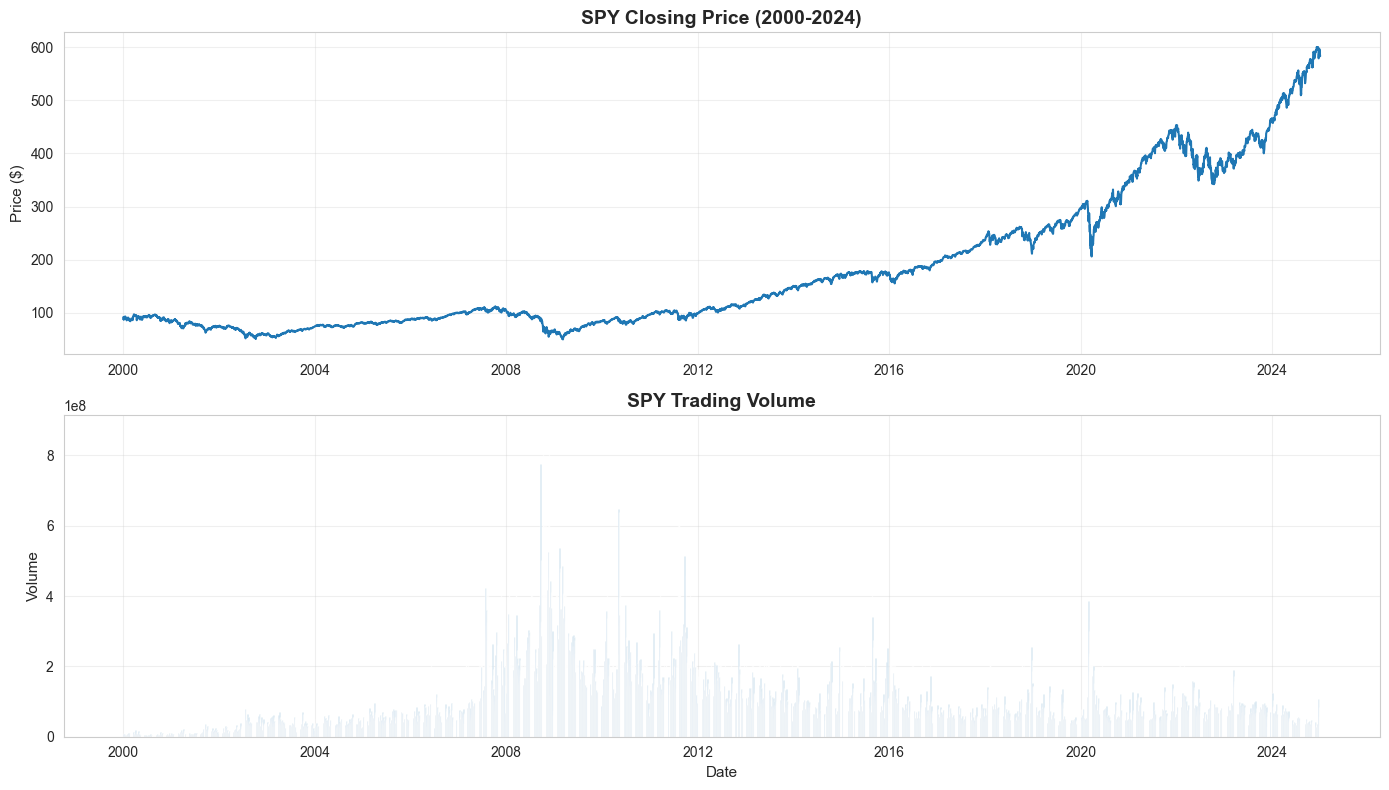


Price range: $50.09 - $600.51
Average daily volume: 106,105,198


In [5]:
# Visualize price history
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price
axes[0].plot(spy_data.index, spy_data['close'], linewidth=1.5)
axes[0].set_title('SPY Closing Price (2000-2024)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Volume
axes[1].bar(spy_data.index, spy_data['volume'], width=1, alpha=0.6)
axes[1].set_title('SPY Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrice range: ${spy_data['close'].min():.2f} - ${spy_data['close'].max():.2f}")
print(f"Average daily volume: {spy_data['volume'].mean():,.0f}")

## Step 2: Calculate Technical Indicators

We'll calculate **21 features** across 4 categories:

### 1. Returns (Price Changes)
- 1-day, 3-day, 5-day, 10-day, 20-day returns
- *Why?* Agent needs to know recent price momentum

### 2. Momentum Indicators
- **RSI** (Relative Strength Index) - Overbought/oversold
- **MACD** (Moving Average Convergence Divergence) - Trend strength
- **Stochastic** - Momentum oscillator
- *Why?* Identify trend reversals and momentum shifts

### 3. Trend Indicators
- **SMA 50/200** (Simple Moving Averages) - Long-term trend
- **EMA 12/26** (Exponential Moving Averages) - Short-term trend
- *Why?* Determine if we're in uptrend, downtrend, or ranging

### 4. Volatility Indicators
- **Bollinger Bands** - Price volatility bands
- **ATR** (Average True Range) - Volatility measure
- *Why?* Manage risk and position sizing

### 5. Volume Indicators
- **OBV** (On-Balance Volume) - Volume momentum
- **Volume Ratio** - Relative volume
- *Why?* Confirm price moves with volume

In [6]:
# Create a copy for feature engineering
data = spy_data.copy()

print("Calculating technical indicators...\n")

# 1. RETURNS
print("[1/5] Returns...")
for period in [1, 3, 5, 10, 20]:
    data[f'return_{period}d'] = data['close'].pct_change(period)

# 2. MOMENTUM INDICATORS
print("[2/5] Momentum indicators (RSI, MACD, Stochastic)...")

# RSI
data['rsi'] = ta.momentum.rsi(data['close'], window=14)
data['rsi_norm'] = (data['rsi'] - 50) / 50  # Normalize to [-1, 1]

# MACD
macd = ta.trend.MACD(data['close'])
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()
data['macd_diff'] = macd.macd_diff()
data['macd_norm'] = data['macd'] / data['close']  # Normalize by price

# Stochastic
stoch = ta.momentum.StochasticOscillator(data['high'], data['low'], data['close'])
data['stoch_k'] = stoch.stoch()
data['stoch_d'] = stoch.stoch_signal()

# 3. TREND INDICATORS
print("[3/5] Trend indicators (SMA, EMA)...")

# Simple Moving Averages
data['sma_50'] = ta.trend.sma_indicator(data['close'], window=50)
data['price_to_sma_50'] = (data['close'] / data['sma_50']) - 1
data['sma_200'] = ta.trend.sma_indicator(data['close'], window=200)
data['price_to_sma_200'] = (data['close'] / data['sma_200']) - 1
data['sma_crossover'] = (data['sma_50'] > data['sma_200']).astype(int)

# Exponential Moving Averages
data['ema_12'] = ta.trend.ema_indicator(data['close'], window=12)
data['price_to_ema_12'] = (data['close'] / data['ema_12']) - 1
data['ema_26'] = ta.trend.ema_indicator(data['close'], window=26)
data['price_to_ema_26'] = (data['close'] / data['ema_26']) - 1

# 4. VOLATILITY INDICATORS
print("[4/5] Volatility indicators (Bollinger Bands, ATR)...")

# Bollinger Bands
bb = ta.volatility.BollingerBands(data['close'])
data['bb_high'] = bb.bollinger_hband()
data['bb_low'] = bb.bollinger_lband()
data['bb_mid'] = bb.bollinger_mavg()
data['bb_percent'] = bb.bollinger_pband()
data['bb_width'] = bb.bollinger_wband()

# ATR
data['atr'] = ta.volatility.average_true_range(data['high'], data['low'], data['close'])
data['atr_pct'] = data['atr'] / data['close']  # As percentage of price

# 5. VOLUME INDICATORS
print("[5/5] Volume indicators (OBV)...")

# On-Balance Volume
data['obv'] = ta.volume.on_balance_volume(data['close'], data['volume'])
data['obv_sma'] = ta.trend.sma_indicator(data['obv'], window=20)
data['obv_std'] = data['obv'].rolling(window=20).std()
data['obv_norm'] = (data['obv'] - data['obv_sma']) / data['obv_std']

# Volume ratio
data['volume_sma'] = ta.trend.sma_indicator(data['volume'], window=20)
data['volume_ratio'] = data['volume'] / data['volume_sma']

print("\n✓ All indicators calculated!")
print(f"  Total features: {len(data.columns) - 6}")

Calculating technical indicators...

[1/5] Returns...
[2/5] Momentum indicators (RSI, MACD, Stochastic)...
[3/5] Trend indicators (SMA, EMA)...
[4/5] Volatility indicators (Bollinger Bands, ATR)...
[5/5] Volume indicators (OBV)...

✓ All indicators calculated!
  Total features: 35


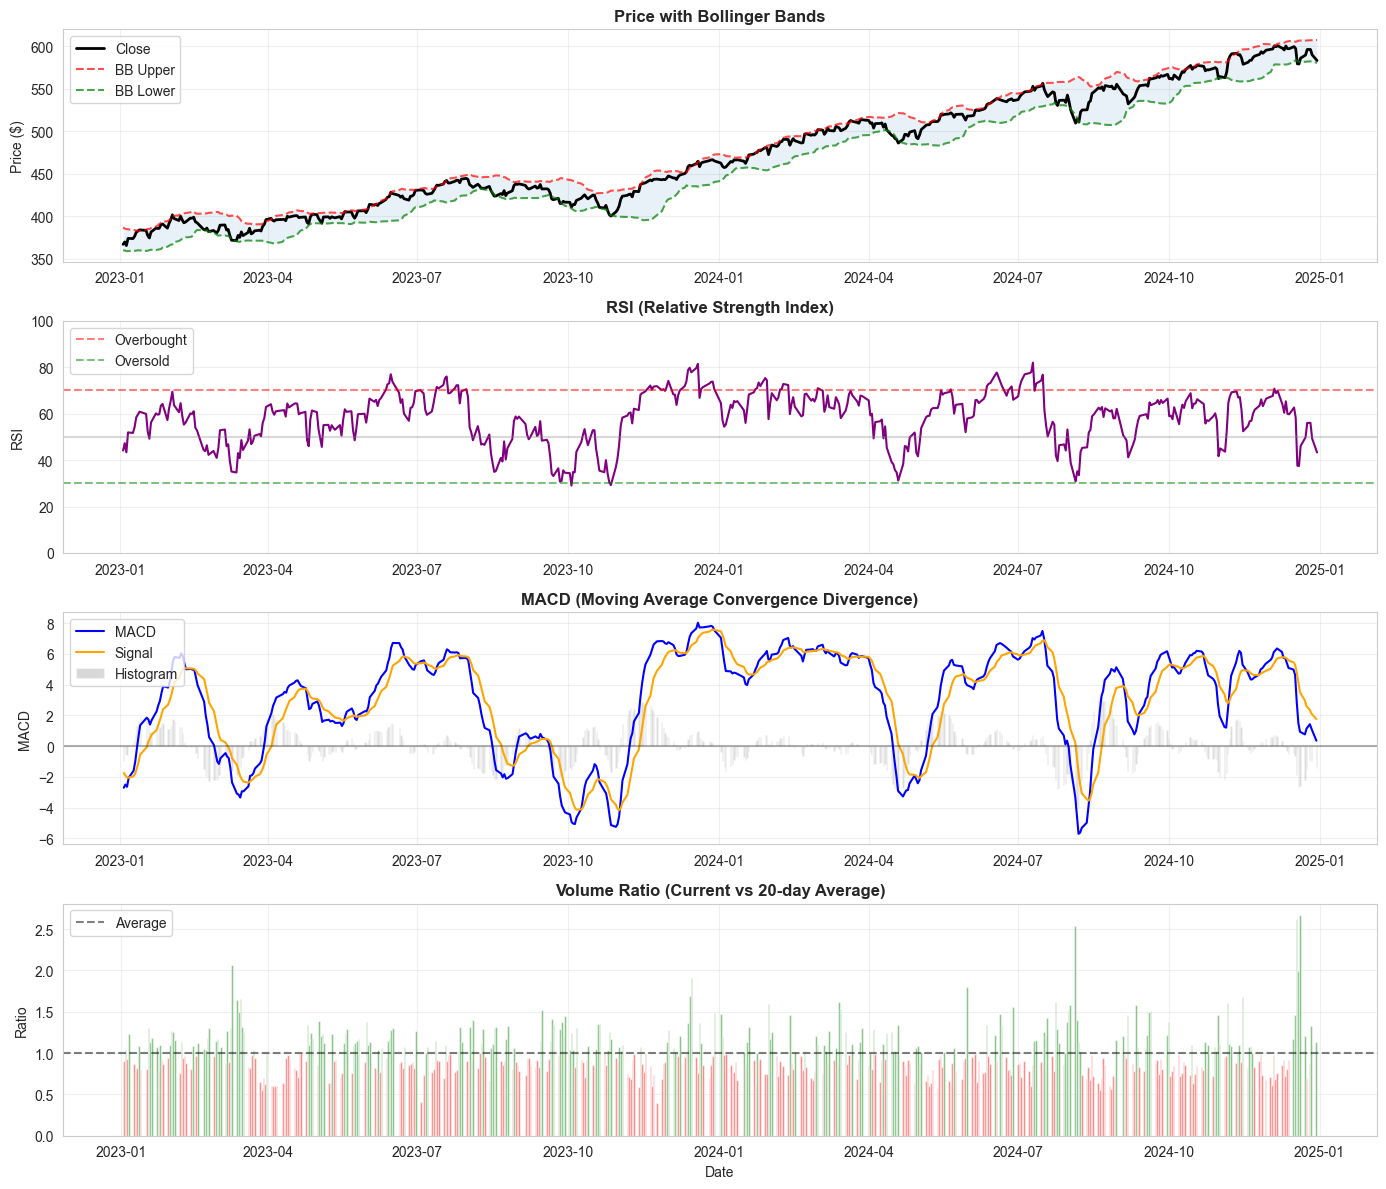

In [7]:
# Visualize some key indicators
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Recent data for better visibility
recent_data = data.loc['2023-01-01':]

# 1. Price with Bollinger Bands
axes[0].plot(recent_data.index, recent_data['close'], label='Close', linewidth=2, color='black')
axes[0].plot(recent_data.index, recent_data['bb_high'], label='BB Upper', linestyle='--', alpha=0.7, color='red')
axes[0].plot(recent_data.index, recent_data['bb_low'], label='BB Lower', linestyle='--', alpha=0.7, color='green')
axes[0].fill_between(recent_data.index, recent_data['bb_low'], recent_data['bb_high'], alpha=0.1)
axes[0].set_title('Price with Bollinger Bands', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. RSI
axes[1].plot(recent_data.index, recent_data['rsi'], linewidth=1.5, color='purple')
axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought')
axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold')
axes[1].axhline(y=50, color='gray', linestyle='-', alpha=0.3)
axes[1].set_title('RSI (Relative Strength Index)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RSI')
axes[1].set_ylim(0, 100)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# 3. MACD
axes[2].plot(recent_data.index, recent_data['macd'], label='MACD', linewidth=1.5, color='blue')
axes[2].plot(recent_data.index, recent_data['macd_signal'], label='Signal', linewidth=1.5, color='orange')
axes[2].bar(recent_data.index, recent_data['macd_diff'], label='Histogram', alpha=0.3, color='gray')
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2].set_title('MACD (Moving Average Convergence Divergence)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MACD')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# 4. Volume Ratio
colors = ['green' if x > 1 else 'red' for x in recent_data['volume_ratio']]
axes[3].bar(recent_data.index, recent_data['volume_ratio'], color=colors, alpha=0.6, width=1)
axes[3].axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Average')
axes[3].set_title('Volume Ratio (Current vs 20-day Average)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Ratio')
axes[3].set_xlabel('Date')
axes[3].legend(loc='upper left')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Data Quality Checks

Before training, we need to ensure:
- No infinite values
- Handle NaN values properly
- Features are on reasonable scales

In [8]:
# Check for missing values
print("Data Quality Report")
print("=" * 50)

missing_counts = data.isnull().sum()
missing_pct = (missing_counts / len(data)) * 100

print("\nMissing values by column:")
missing_df = pd.DataFrame({
    'Missing': missing_counts,
    'Percent': missing_pct
}).query('Missing > 0').sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
    print(f"\nTotal rows with any missing: {data.isnull().any(axis=1).sum()}")
else:
    print("No missing values found!")

# Check for infinite values
inf_counts = np.isinf(data.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print(f"\n⚠ Warning: {inf_counts.sum()} infinite values found")
    print(inf_counts[inf_counts > 0])
else:
    print("\n✓ No infinite values")

Data Quality Report

Missing values by column:
                  Missing   Percent
Price                              
sma_200               199  3.164758
price_to_sma_200      199  3.164758
sma_50                 49  0.779262
price_to_sma_50        49  0.779262
macd_signal            33  0.524809
macd_diff              33  0.524809
macd_norm              25  0.397583
ema_26                 25  0.397583
price_to_ema_26        25  0.397583
macd                   25  0.397583
return_20d             20  0.318066
bb_mid                 19  0.302163
bb_percent             19  0.302163
bb_low                 19  0.302163
bb_high                19  0.302163
obv_std                19  0.302163
obv_norm               19  0.302163
bb_width               19  0.302163
obv_sma                19  0.302163
volume_sma             19  0.302163
volume_ratio           19  0.302163
stoch_d                15  0.238550
rsi                    13  0.206743
stoch_k                13  0.206743
rsi_norm         

In [9]:
# Drop initial rows with NaN (from indicator calculations)
print("\nCleaning data...")
print(f"  Before: {len(data)} rows")

data_clean = data.dropna()

print(f"  After: {len(data_clean)} rows")
print(f"  Removed: {len(data) - len(data_clean)} rows ({((len(data) - len(data_clean))/len(data)*100):.1f}%)")

# Replace any remaining inf with NaN and drop
data_clean = data_clean.replace([np.inf, -np.inf], np.nan).dropna()

print(f"\n✓ Clean data: {len(data_clean)} rows")
print(f"  Date range: {data_clean.index[0].date()} to {data_clean.index[-1].date()}")


Cleaning data...
  Before: 6288 rows
  After: 6089 rows
  Removed: 199 rows (3.2%)

✓ Clean data: 6089 rows
  Date range: 2000-10-16 to 2024-12-30


## Step 4: Feature Statistics

Let's look at the distribution of our features to ensure they're reasonable.

In [10]:
# Select the 21 features we'll use for the agent
feature_cols = [
    # Returns
    'return_1d', 'return_5d', 'return_10d',
    # Momentum
    'rsi', 'rsi_norm', 'macd', 'macd_signal', 'macd_diff',
    # Trend
    'sma_50', 'sma_200', 'sma_crossover', 'ema_12', 'ema_26',
    # Volatility
    'bb_high', 'bb_low', 'bb_width', 'bb_percent', 'atr', 'atr_pct',
    # Volume
    'volume_ratio', 'obv'
]

# Summary statistics
print("Feature Statistics (21 features for agent)")
print("=" * 80)
stats = data_clean[feature_cols].describe()
print(stats.T[['mean', 'std', 'min', 'max']])

Feature Statistics (21 features for agent)
                       mean           std           min           max
Price                                                                
return_1d      3.850083e-04  1.212512e-02 -1.094237e-01  1.451973e-01
return_5d      1.879470e-03  2.463376e-02 -1.979337e-01  1.940362e-01
return_10d     3.675919e-03  3.331878e-02 -2.676870e-01  2.158058e-01
rsi            5.472394e+01  1.145559e+01  1.680284e+01  8.719094e+01
rsi_norm       9.447886e-02  2.291118e-01 -6.639431e-01  7.438187e-01
macd           5.721309e-01  2.401606e+00 -2.167835e+01  8.979175e+00
macd_signal    5.700975e-01  2.248237e+00 -1.814305e+01  7.964643e+00
macd_diff      2.033421e-03  7.560836e-01 -5.636846e+00  5.627433e+00
sma_50         1.811991e+02  1.291523e+02  5.592216e+01  5.859055e+02
sma_200        1.755260e+02  1.221293e+02  5.779424e+01  5.451505e+02
sma_crossover  7.191657e-01  4.494436e-01  0.000000e+00  1.000000e+00
ema_12         1.827506e+02  1.311516e+02  5.33

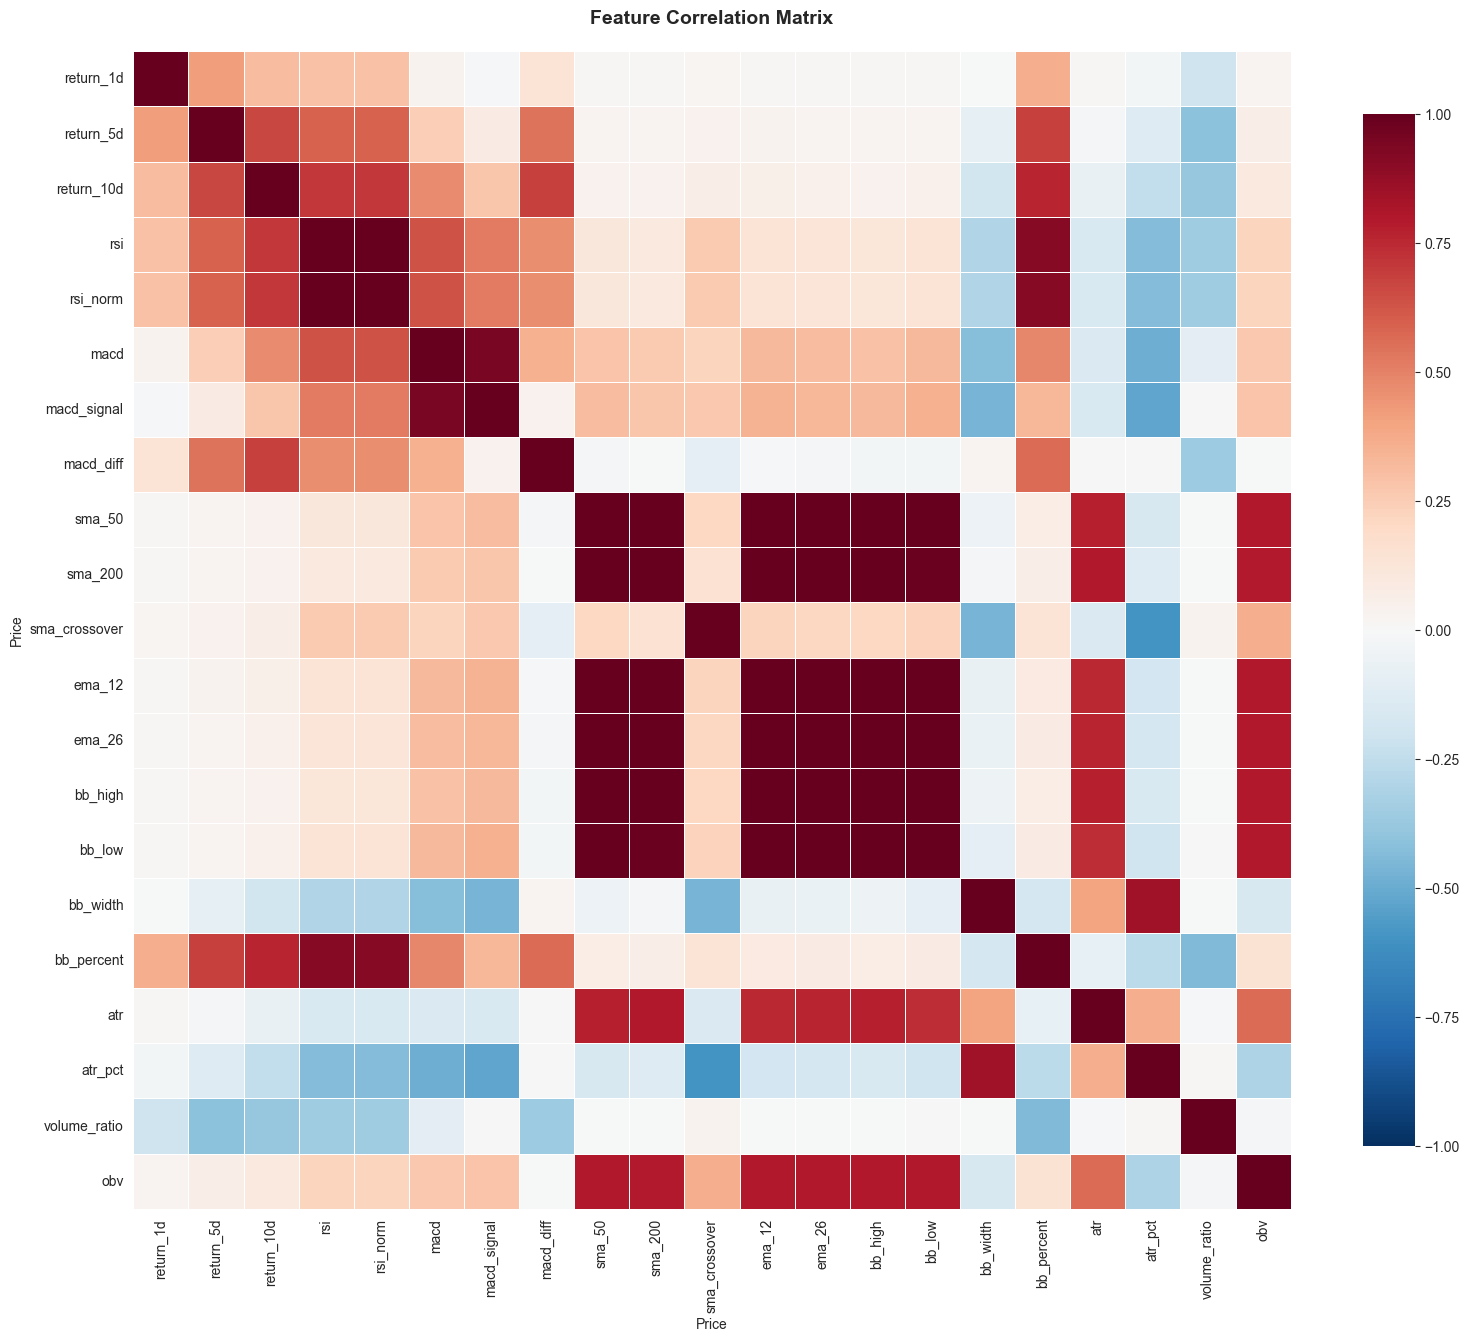


Highly correlated feature pairs (|corr| > 0.8):
  rsi <-> rsi_norm: 1.000
  rsi <-> bb_percent: 0.908
  rsi_norm <-> bb_percent: 0.908
  macd <-> macd_signal: 0.949
  sma_50 <-> sma_200: 0.996
  sma_50 <-> ema_12: 0.999
  sma_50 <-> ema_26: 1.000
  sma_50 <-> bb_high: 0.999
  sma_50 <-> bb_low: 0.998
  sma_50 <-> obv: 0.800
  sma_200 <-> ema_12: 0.994
  sma_200 <-> ema_26: 0.995
  sma_200 <-> bb_high: 0.996
  sma_200 <-> bb_low: 0.992
  sma_200 <-> atr: 0.804
  ema_12 <-> ema_26: 1.000
  ema_12 <-> bb_high: 0.999
  ema_12 <-> bb_low: 0.999
  ema_12 <-> obv: 0.801
  ema_26 <-> bb_high: 1.000
  ema_26 <-> bb_low: 0.999
  ema_26 <-> obv: 0.801
  bb_high <-> bb_low: 0.998
  bb_low <-> obv: 0.802
  bb_width <-> atr_pct: 0.845


In [11]:
# Correlation heatmap
plt.figure(figsize=(16, 14))
corr = data_clean[feature_cols].corr()
sns.heatmap(corr, cmap='RdBu_r', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.8:
            high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

if high_corr:
    print("\nHighly correlated feature pairs (|corr| > 0.8):")
    for f1, f2, corr_val in high_corr:
        print(f"  {f1} <-> {f2}: {corr_val:.3f}")
else:
    print("\n✓ No highly correlated features (all |corr| <= 0.8)")

## Step 5: Save Processed Data

Save the clean, feature-engineered data for use in training.

In [12]:
# Create output directory
output_dir = Path('demo_data')
output_dir.mkdir(exist_ok=True)

# Save to parquet (efficient format)
output_path = output_dir / 'featured_data.parquet'
data_clean.to_parquet(output_path)

print(f"✓ Data saved to: {output_path}")
print(f"  Rows: {len(data_clean):,}")
print(f"  Columns: {len(data_clean.columns)}")
print(f"  Features for agent: {len(feature_cols)}")
print(f"  File size: {output_path.stat().st_size / 1024:.1f} KB")

# Also save feature list for reference
feature_info = pd.DataFrame({
    'feature': feature_cols,
    'mean': data_clean[feature_cols].mean(),
    'std': data_clean[feature_cols].std(),
    'min': data_clean[feature_cols].min(),
    'max': data_clean[feature_cols].max()
})
feature_info.to_csv(output_dir / 'feature_info.csv', index=False)
print(f"\n✓ Feature info saved to: {output_dir / 'feature_info.csv'}")

✓ Data saved to: demo_data\featured_data.parquet
  Rows: 6,089
  Columns: 41
  Features for agent: 21
  File size: 2220.2 KB

✓ Feature info saved to: demo_data\feature_info.csv


## Summary

### What We Accomplished

✅ Downloaded 20+ years of SPY historical data  
✅ Calculated **21 technical indicators** across 5 categories  
✅ Cleaned data (removed NaN and inf values)  
✅ Validated feature quality and correlations  
✅ Saved processed data for training  

### Data Summary

- **Asset:** SPY (S&P 500 ETF)
- **Time Period:** 2000-2024 (~25 years)
- **Total Rows:** ~6,000 trading days
- **Features:** 21 technical indicators
- **Data Quality:** Clean, no missing/infinite values

### Next Steps

**→ Notebook 02:** Cross-Validation & Data Splits  
We'll split this data into train/validation/test sets properly for time-series.